In [1]:
import os
import sys
sys.path.append('./src')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import yaml

from datasets import build_dataset, build_transforms
from denoiser import get_denoiser
from models import create_vae

import matplotlib.pyplot as plt
import numpy as np

from backbones import get_backbone
from denoiser import get_denoiser, Denoiser
from models import create_vae, AutoencoderKL, create_mar_model, MaskedImageModelingModelWithDiffusion

/home/haselab/anaconda3/envs/anomar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [267]:
category = "splicing_connectors"
num_inference_steps = 100
device = 'cuda'
num_samples = 4
start_step = 96

In [268]:
from torch.utils.data import DataLoader
import torch

normal_dataset = build_dataset(
    dataset_name='mvtec_loco',
    data_root = "data/mvtec_loco",
    train=False,
    img_size=224,
    transform_type="default",
    category = category,
    normal_only = True
)
anom_dataset = build_dataset(
    dataset_name='mvtec_loco',
    data_root = "data/mvtec_loco",
    train=False,
    img_size=224,
    transform_type="default",
    category = category,
    anom_only = True
)
print(len(normal_dataset))
print(len(anom_dataset))

119
193


In [269]:
log_dir = f"./results/ad_mar_ca_base_vae_loco_uncond/{category}"
config_path = os.path.join(log_dir, "config.yaml")
ckpt_path = os.path.join(log_dir, "model_latest.pth")

with open(config_path, 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

seed = config['meta']['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

config["diffusion"]["num_sampling_steps"] = str(num_inference_steps)
img_size = config['data']['img_size']
device = device
num_samples = num_samples

# build backbone model
if 'vae' in config['backbone']['model_type']:
    backbone = create_vae(**config['backbone'])
else:
    backbone = get_backbone(**config['backbone'])
backbone.to(device).eval()

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from ./weights/vae/kl16.ckpt


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

In [270]:
backbone_embed_dim = config['backbone']['embed_dim']
backbone_stride = config['backbone']['stride']
img_size = config['data']['img_size']
patch_size = config['mim']['patch_size']
mim_in_sh = (backbone_embed_dim, img_size // backbone_stride, img_size // backbone_stride)

denoiser: Denoiser = get_denoiser(**config['diffusion'], input_shape=mim_in_sh)
model = create_mar_model(denoiser, **config['mim'])
model_ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=True)
results = model.load_state_dict(model_ckpt, strict=False)
print(results)
model.to(device).eval()

_IncompatibleKeys(missing_keys=['denoiser.net.blocks.0.cross_attn.q.weight', 'denoiser.net.blocks.0.cross_attn.q.bias', 'denoiser.net.blocks.0.cross_attn.kv.weight', 'denoiser.net.blocks.0.cross_attn.kv.bias', 'denoiser.net.blocks.1.cross_attn.q.weight', 'denoiser.net.blocks.1.cross_attn.q.bias', 'denoiser.net.blocks.1.cross_attn.kv.weight', 'denoiser.net.blocks.1.cross_attn.kv.bias', 'denoiser.net.blocks.2.cross_attn.q.weight', 'denoiser.net.blocks.2.cross_attn.q.bias', 'denoiser.net.blocks.2.cross_attn.kv.weight', 'denoiser.net.blocks.2.cross_attn.kv.bias', 'denoiser.net.blocks.3.cross_attn.q.weight', 'denoiser.net.blocks.3.cross_attn.q.bias', 'denoiser.net.blocks.3.cross_attn.kv.weight', 'denoiser.net.blocks.3.cross_attn.kv.bias'], unexpected_keys=['denoiser.net.blocks.0.cross_attn.qkv.weight', 'denoiser.net.blocks.0.cross_attn.qkv.bias', 'denoiser.net.blocks.1.cross_attn.qkv.weight', 'denoiser.net.blocks.1.cross_attn.qkv.bias', 'denoiser.net.blocks.2.cross_attn.qkv.weight', 'denois

MaskedImageModelingModelWithDiffusion(
  (denoiser): Denoiser(
    (cls_embed): Embedding(15, 256)
    (net): DiT(
      (x_embedder): PatchEmbed(
        (proj): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
        (norm): Identity()
      )
      (x_embedder_linear): Linear(in_features=16, out_features=256, bias=True)
      (z_embedder): ConditionEmbedder(
        (mlp): Sequential(
          (0): Linear(in_features=16, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (t_embedder): TimestepEmbedder(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): SiLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
      (y_embedder): LabelEmbedder(
        (embedding_table): Embedding(15, 256)
      )
      (blocks): ModuleList(
        (0-3): 4 x DiTBlockWithCrossAttention(
          (norm1): LayerNo

In [271]:
from mask import RandomMaskCollator, BlockRandomMaskCollator, CheckerBoardMaskCollator, indices_to_mask, mask_to_indices
mask_strategy = config['data']['mask']['strategy']
mask_ratio = config['data']['mask']['ratio']

if mask_strategy == "random":
    mask_collator = RandomMaskCollator(
        ratio=mask_ratio, input_size=mim_in_sh[1], patch_size=patch_size
    )
elif mask_strategy == "block":
    mask_collator = BlockRandomMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, mask_ratio=mask_ratio, **config['data']['mask']
    )
elif mask_strategy == "checkerboard":
    mask_collator = CheckerBoardMaskCollator(
        input_size=mim_in_sh[1], patch_size=patch_size, **config['data']['mask']
    )
else:
    raise ValueError(f"Invalid mask strategy: {mask_strategy}")

bs = 4

normal_dataloader = DataLoader(normal_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False, collate_fn=mask_collator)
anom_dataloader = DataLoader(anom_dataset, batch_size=bs, shuffle=False, num_workers=4, drop_last=False, collate_fn=mask_collator)

In [272]:
batch, mask_indices = list(anom_dataloader)[30]
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, model.num_patches)
mask = mask.to(device)

mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
gt_masks = batch["masks"]  # (B, 1, H, W) 

In [273]:
from einops import rearrange

@torch.no_grad()
def encode_images(x):
    if 'vae' in config['backbone']['model_type']:
        post = backbone.encode(x)
        return post.sample().mul_(0.2325)
    else:
        return backbone(x)

@torch.no_grad()
def decode_images(x):
    if 'vae' in config['backbone']['model_type']:
        return backbone.decode(x / 0.2325)
    else:
        raise ValueError(f"Backbone {config['backbone']['model_type']} does not support decoding")

def reshape_mask(m):  
    """ (B, hw) -> (B, hp, wp) """
    m = rearrange(m, 'b (h w) -> b h w', h=mim_in_sh[1], w=mim_in_sh[2])
    m = torch.repeat_interleave(m, repeats=patch_size, dim=1)
    m = torch.repeat_interleave(m, repeats=patch_size, dim=2)
    m = m.float()
    return m

In [274]:
# 1. MIM Prediction 
with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)
    
# 2. Denoising on masked tokens
denoiser = model.denoiser
t = torch.tensor([start_step] * num_samples * len(images)).to(device)

def perturb(z, t):
    z = z.repeat_interleave(num_samples, dim=0)  # (B*K, M, c*p*p)
    noised_z = denoiser.q_sample(z, t)  # (B*K, M, c*p*p)
    return noised_z, z

noised_targets, org_targets = perturb(target, t)  # (B*K, M, c*p*p)

In [275]:
@torch.no_grad()
def denoising(noised_z, t, labels, cond, mask_indices):
    cond = cond.repeat_interleave(num_samples, dim=0)  # (B*K, M, c*p*p)
    labels = labels.repeat_interleave(num_samples, dim=0)  # (B*K)
    mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
    denoized_z = denoiser.denoise_from_intermediate(noised_z, t, labels, cond, mask_indices)  # (B*K, M, c*p*p)
    return denoized_z

preds = denoising(noised_targets, t, labels, cond, mask_indices)  # (B*K, M, c*p*p)
mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
latents = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
latents = latents.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)
pred_latents = latents.clone()
pred_latents[torch.arange(len(pred_latents)).unsqueeze(1), mask_indices] = preds  # (B*K, N, c)
pred_latents_map = rearrange(pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

In [276]:
from torch.nn import functional as F

def postprocess(x):
    x = x / 2 + 0.5
    return x.clamp(0, 1)

def convert2image(x):
    if x.dim() == 3:
        return x.permute(1, 2, 0).cpu().numpy()
    elif x.dim() == 4:
        return x.permute(0, 2, 3, 1).cpu().numpy()
    else:
        return x.cpu().numpy()

pred_imgs = decode_images(pred_latents_map)  # (B*K, 3, H, W)
mask = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - mask))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  

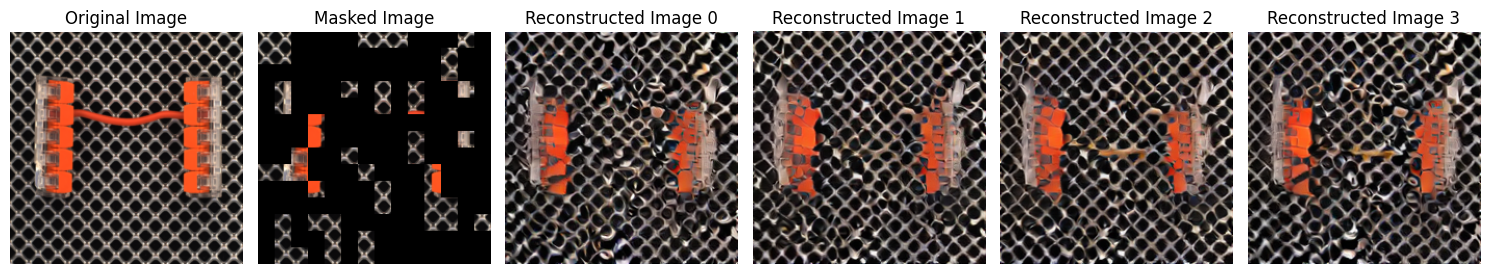

In [277]:
# Plot reconstruction
org_img = org_imgs[0]
masked_img = masked_imgs[0]
pred_img = pred_imgs[0]  # (K, H, W, C)

fig, ax = plt.subplots(1, 2 + num_samples, figsize=(15, 5))
ax[0].imshow(org_img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(masked_img)
ax[1].set_title("Masked Image")
ax[1].axis('off')
ax[2].imshow(pred_img[0])
ax[2].set_title("Reconstructed Image 0")
ax[2].axis('off')
for i in range(num_samples-1):
    ax[3 + i].imshow(pred_img[i+1])
    ax[3 + i].set_title(f"Reconstructed Image {i+1}")
    ax[3 + i].axis('off')

plt.tight_layout()
plt.show()

## VIsu

In [278]:
batch, mask_indices = list(normal_dataloader)[3]
# ensure same mask for all samples
mask_indices = torch.stack([mask_indices[0] for _ in range(bs)])

mask = indices_to_mask(mask_indices, model.num_patches)
mask = mask.to(device)

mask_indices = mask_indices.to(device)
images = batch["samples"].to(device)
labels = batch["clslabels"].to(device)
gt_masks = batch["masks"]  # (B, 1, H, W) 

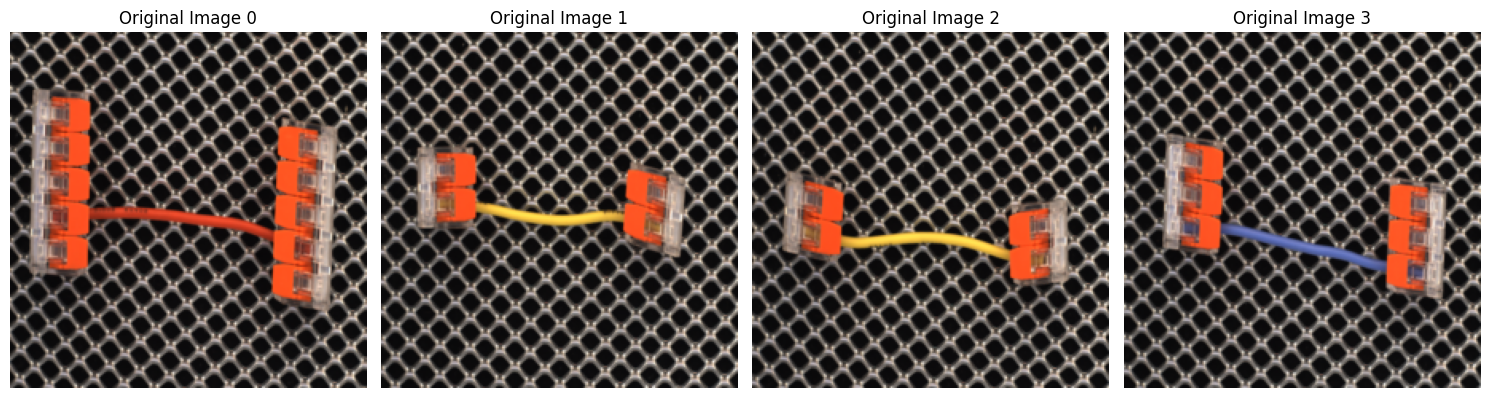

In [279]:
# Show original images
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
fig, ax = plt.subplots(1, bs, figsize=(15, 5))
for i in range(bs):
    ax[i].imshow(org_imgs[i])
    ax[i].set_title(f"Original Image {i}")
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [280]:
# 1. MIM Prediction
with torch.no_grad():
    latents = encode_images(images)
    outputs = model.masked_forward(latents, mask)  # (B)
    cond, target = outputs['preds'], outputs['targets']  # (B, M, c*p*p)

# Set target latents to 0-th sample
latents = torch.stack([latents[0] for _ in range(bs)])  # (B, N, c)
target = torch.stack([target[0] for _ in range(bs)])  # (B, M, c*p*p)
noised_targets, org_targets = perturb(target, t)  # (B*K, M, c*p*p)

# Denoising on masked tokens
preds = denoising(noised_targets, t, labels, cond, mask_indices)  # (B*K, M, c*p*p)
mask_indices = mask_indices.repeat_interleave(num_samples, dim=0)  # (B*K, M)
latents = rearrange(latents, 'b c (h p1) (w p2) -> b (h w) (c p1 p2)', h=mim_in_sh[1], w=mim_in_sh[2], p1=patch_size, p2=patch_size)
latents = latents.repeat_interleave(num_samples, dim=0)  # (B*K, N, c)
pred_latents = latents.clone()
pred_latents[torch.arange(len(pred_latents)).unsqueeze(1), mask_indices] = preds  # (B*K, N, c)
pred_latents_map = rearrange(pred_latents, 'b (h w) c -> b c h w', h=mim_in_sh[1], w=mim_in_sh[2])  # (B*K, c, h, w)

In [281]:
pred_imgs = decode_images(pred_latents_map)  # (B*K, 3, H, W)
mask = reshape_mask(mask).unsqueeze(1)  # (B, H, W)
org_imgs = convert2image(postprocess(images))  # (B, H, W, C)
mask = F.interpolate(mask, size=(img_size, img_size), mode='nearest')  # (B, 1, H, W)
masked_imgs = convert2image(postprocess(images) * (1 - mask))  # (B, H, W, C)
pred_imgs = convert2image(postprocess(pred_imgs)) # (B*K, H, W, C)
pred_imgs = pred_imgs.reshape(-1, num_samples, *pred_imgs.shape[1:]) # (B, K, H, W, C)  

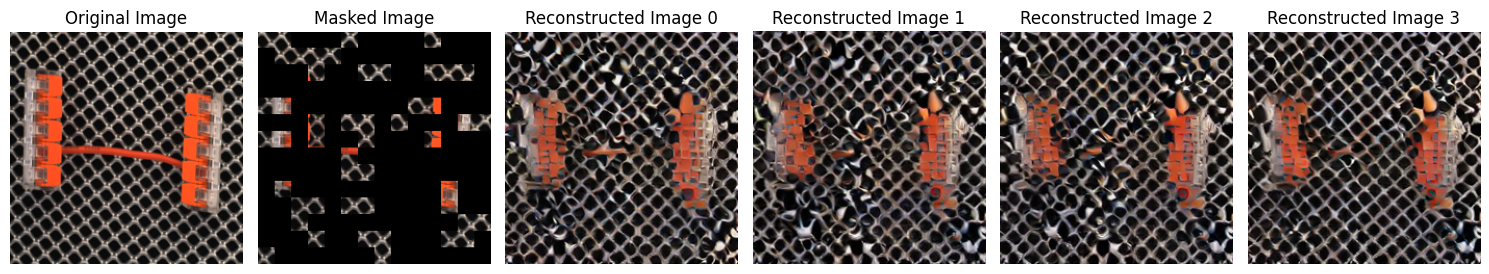

In [282]:
# Plot reconstruction
org_img = org_imgs[0]
masked_img = masked_imgs[0]
pred_img = pred_imgs[:, 0]  # (B, H, W, C), extract 0-th sample

fig, ax = plt.subplots(1, 2 + num_samples, figsize=(15, 5))
ax[0].imshow(org_img)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(masked_img)
ax[1].set_title("Masked Image")
ax[1].axis('off')
ax[2].imshow(pred_img[0])
ax[2].set_title("Reconstructed Image 0")
ax[2].axis('off')
for i in range(num_samples-1):
    ax[3 + i].imshow(pred_img[i+1])
    ax[3 + i].set_title(f"Reconstructed Image {i+1}")
    ax[3 + i].axis('off')

plt.tight_layout()
plt.show()